In [ ]:
#!/bin/env python

from __future__ import absolute_import, division, print_function, unicode_literals

import sys,os,os.path,time
sys.path.append(os.path.expanduser('/global/u1/r/rgupta2/.local/lib/python3.7/site-packages/'))

# export PYTHONPATH="${PYTHONPATH}:/usr/local/lib/python2.7/site-packages:/usr/lib/python2.7/site-packages"


import matplotlib.style
import matplotlib as mpl
mpl.use('Agg')
# mpl.style.use('seaborn')
mpl.rc('image', cmap='gray')
import matplotlib.pyplot as plt
	
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,10)


import time, re, sys, os
from tqdm import tqdm, trange
import cv2
import pandas as pd
import xarray as xr
from glob import glob
import numpy as np
from scipy import stats
# Install a pip package in the current Jupyter kernel
# !{sys.executable} -m pip install --user Pillow

from PIL import Image



In [2]:
import tensorflow as tf
print(tf.__version__)
tf.enable_eager_execution()


1.15.0


In [11]:
# 
original_file_path = "/global/cscratch1/sd/karthik_/CAM5.1_0.25degree/"
original_files = sorted(glob(original_file_path + "*.nc"))
print(len(original_files)) # 1321
# image  dimension (ilev: 31, lat: 768, lev: 30, lon: 1152, nbnd: 2, slat: 767, slon: 1152, time: 8)
#  8 x 768 x 1152

# plotting one random image from the real data
# ds = xr.open_dataset(original_files[0], decode_times=False	)
# data = ds["OMEGA500"][:, 128:640, 320:832].values

  

0


In [26]:
list_of_omega_data = []    
for _, file in tqdm(enumerate(original_files)):
    tmp_ds = xr.open_dataset(file, decode_times=False)
    list_of_omega_data.append( np.expand_dims(tmp_ds["OMEGA500"][:, 128:640, 320:832].values, axis=1))
    


125it [01:25,  1.56it/s]


In [27]:
numpy_array_of_omega = np.squeeze(np.concatenate(list_of_omega_data, axis=0))
np.random.shuffle(numpy_array_of_omega)
print(numpy_array_of_omega.shape)




(1000, 512, 512)


In [17]:

# Only useful when you want to resize images

result = []
def my_resize(z, res=256):
    return  np.array(Image.fromarray(z).resize(size = (res,res), resample= PIL.Image.BILINEAR ))
for image in numpy_array_of_omega:
    result.append(my_resize(image,))

    
tmp_real_val = np.stack(result, axis=0)
print(tmp_real_val.shape)

(1000, 256, 256)


In [28]:
# generated_images_npy
# 159490 the most recent generator counter
# climate_counter = 255468

climate_counter = 329218

climate_npy_files = "/global/cscratch1/sd/rgupta2/backup/climate_stylegan/stored_outputs/wo_norm_512/result/single_generator_results/generator_{}_images_50_file_*.npy".format(climate_counter)
generated_files = sorted(glob(climate_npy_files))[:]

print("Number of files : {}".format(len(generated_files)))

generated_image_list = []
for file in generated_files:
    my_dict_back = np.load(file, allow_pickle=True)	
    generated_images = my_dict_back.item()["generated_images"]
#     print(generated_images.shape)
    generated_image_list.append(np.squeeze(generated_images))
    
generated_images_new = np.concatenate(generated_image_list, axis=0)


print(generated_image_list[0].shape)
print(generated_images_new.shape)


Number of files : 8
(50, 512, 512)
(400, 512, 512)


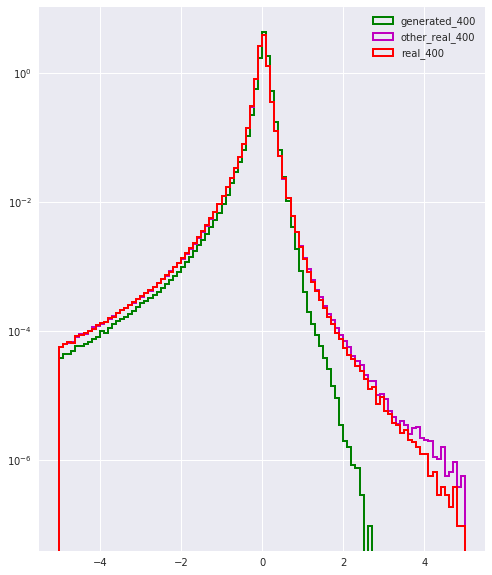

In [29]:

plt.hist([numpy_array_of_omega[:400].flatten(), numpy_array_of_omega[600:].flatten(),  generated_images_new.flatten() ], color=['r', 'm', 'g'], bins=100, range=[-5,5], linewidth=2 ,histtype='step', label=["real_400", "other_real_400", "generated_400"], density=True)
plt.yscale("log")
plt.legend(loc='best')
plt.savefig("wo_norm_512_plot_329218_400_images.png", dpi=200)

In [ ]:

# to shuffle_or not
np.random.shuffle(tmp_real_val)
# resized_image =  res.resize((256,256), Image.BILINEAR)

(256, 256)


In [24]:

# generated_images_npy
# 159490 the most recent generator counter
climate_counter = 159490
climate_npy_files = "/global/cscratch1/sd/rgupta2/backup/climate_stylegan/stored_outputs/wo_norm/result/single_generator_results/generator_{}_images_50_file_*.npy".format(climate_counter)
generated_files = sorted(glob(climate_npy_files))[:6]

print("Number of files : {}".format(len(generated_files)))

generated_image_list = []
for file in generated_files:
    my_dict_back = np.load(file, allow_pickle=True)	
    generated_images = my_dict_back.item()["generated_images"]
#     print(generated_images.shape)
    generated_image_list.append(np.squeeze(generated_images))
    
generated_images = np.concatenate(generated_image_list, axis=0)


print(generated_image_list[0].shape)
print(generated_images.shape)


Number of files : 7
(50, 256, 256)
(350, 256, 256)


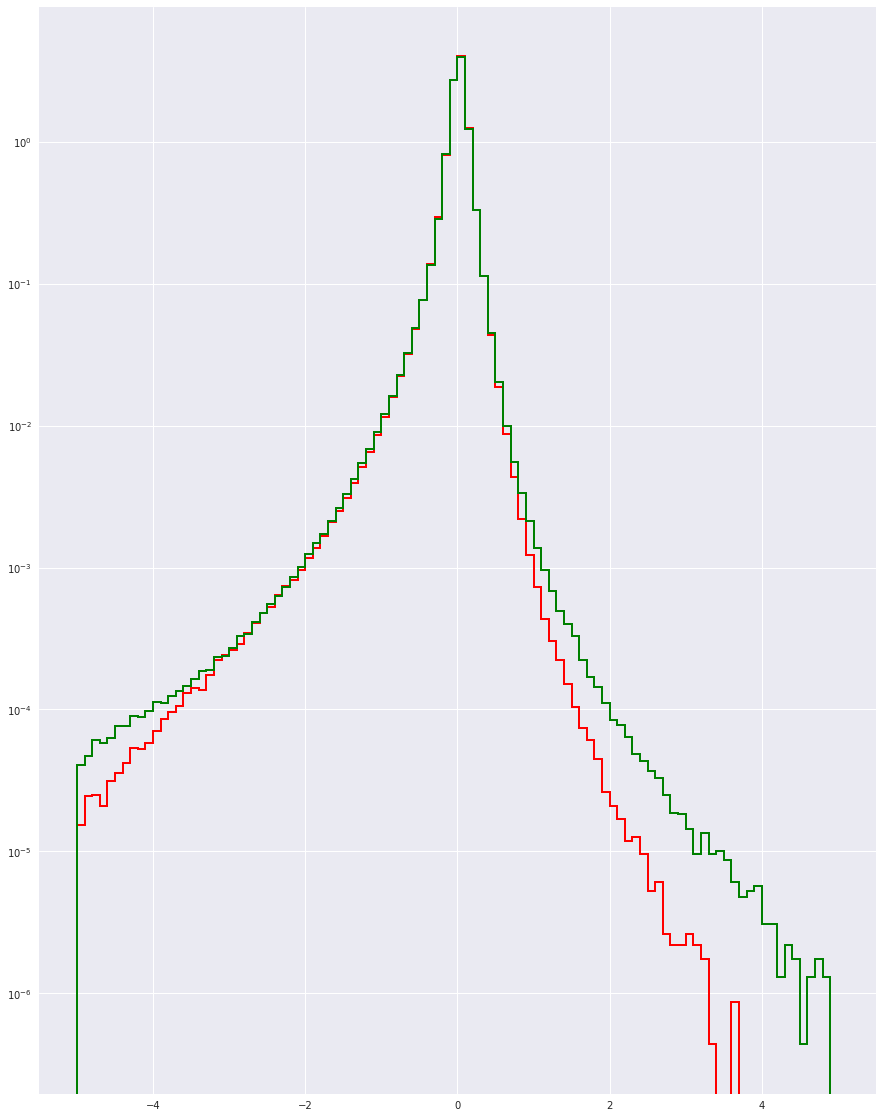

In [37]:

plt.hist([generated_images.flatten(), tmp_real_val[:350].flatten(), generated_images], color=['g', 'r'], bins=100, range=[-5,5], linewidth=2 ,histtype='step', label="{}".format("generated"), density=True)
plt.yscale("log")

In [29]:
input_t = tmp_real_val# shape 1000 x 256 x 256 
input_t = np.expand_dims(input_t, axis=3)
print(input_t.shape)
num_channels =1
real_avg = tf.nn.avg_pool(value=input_t,
                      ksize=[1, 2, 2, 1],
                      strides=[1, 2, 2, 1],
                      padding="SAME")







(1000, 256, 256, 1)


In [43]:

input_t = generated_images_new  # shape 350 x 256 x 256 
input_t = np.expand_dims(input_t, axis=3)
print(input_t.shape)
generated_avg = tf.nn.avg_pool(value=input_t,
                      ksize=[1, 2, 2, 1],
                      strides=[1, 2, 2, 1],
                      padding="SAME")

(450, 256, 256, 1)


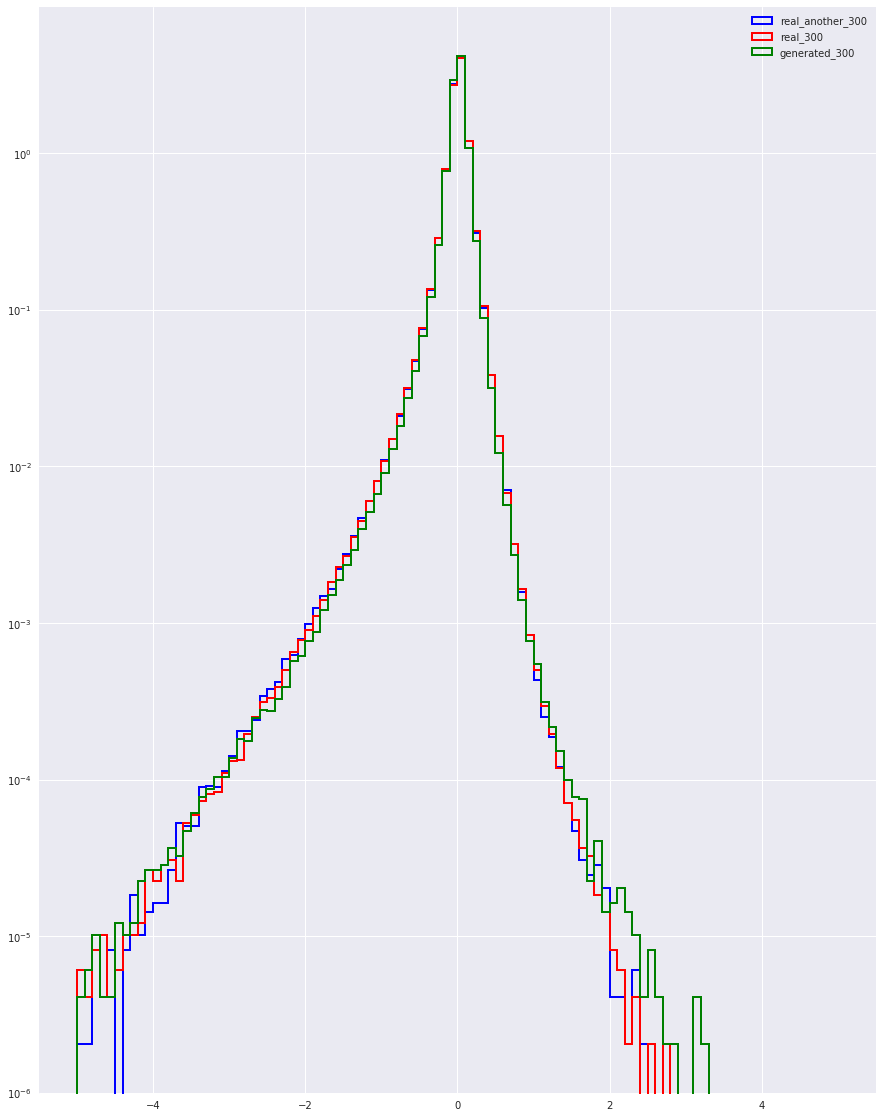

In [44]:

plt.hist([generated_avg[:300].numpy().flatten(), real_avg[-300:].numpy().flatten(), real_avg[:300].numpy().flatten() ], color=['g', 'r', 'b'], bins=100, range=[-5,5], linewidth=2 ,histtype='step', label=["generated_300", "real_300", "real_another_300"], density=True)
plt.yscale("log")
plt.legend(loc='best')
plt.savefig("avgpooling_pdf_plot.png", dpi=200)

In [2]:

plt.hist([tmp_real_val[:100].flatten(), tmp_real_val[-100:].flatten()], color=['g', 'r'], bins=100, range=[-5,5], linewidth=2 ,histtype='step', label="{}".format("generated"))
plt.yscale("log")

NameError: name 'tmp_real_val' is not defined

In [39]:

# generated_images_npy
# 159490 the most recent generator counter
climate_counter = 159490
climate_npy_files = "/global/cscratch1/sd/rgupta2/backup/climate_stylegan/stored_outputs/wo_norm/result/single_generator_results/generator_{}_images_50_file_*.npy".format(climate_counter)
generated_files = sorted(glob(climate_npy_files))[:9]

print("Number of files : {}".format(len(generated_files)))

generated_image_list = []
for file in generated_files:
    my_dict_back = np.load(file, allow_pickle=True)	
    generated_images = my_dict_back.item()["generated_images"]
#     print(generated_images.shape)
    generated_image_list.append(np.squeeze(generated_images))
    
generated_images_new = np.concatenate(generated_image_list, axis=0)


print(generated_image_list[0].shape)
print(generated_images_new.shape)


Number of files : 9
(50, 256, 256)
(450, 256, 256)


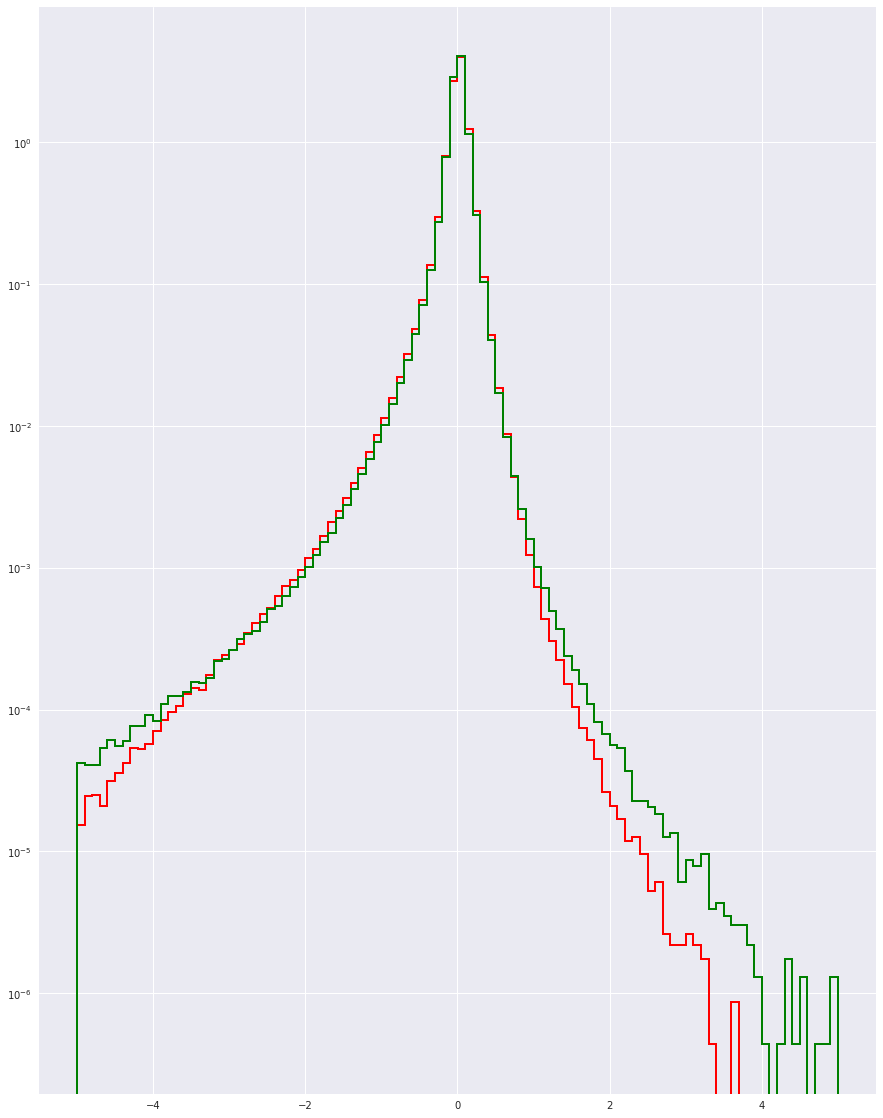

In [41]:

plt.hist([generated_images_new[:350].flatten(), tmp_real_val[:350].flatten()], color=['g', 'r'], bins=100, range=[-5,5], linewidth=2 ,histtype='step', label="{}".format("generated"), density=True)
plt.yscale("log")

In [ ]:


import scipy.signal as signal

sample_rate, samples = wav.read(filename)
f, t, Zxx = signal.stft(samples, fs=sample_rate)
plt.pcolormesh(t, f, np.abs(Zxx), cmap=cmap)

In [11]:
climate_counter = 159490
climate_npy_files = "/global/cscratch1/sd/rgupta2/backup/climate_stylegan/stored_outputs/wo_norm/result/single_generator_results/generator_{}_images_50_file_*.npy".format(climate_counter)
generated_files = sorted(glob(climate_npy_files))[:10]

print("Number of files : {}".format(len(generated_files)))

generated_image_list = []
for file in generated_files:
    my_dict_back = np.load(file, allow_pickle=True)	
    generated_images = my_dict_back.item()["generated_images"]
#     print(generated_images.shape)
    generated_image_list.append(np.squeeze(generated_images))
    
save_path = "/global/cscratch1/sd/rgupta2/backup/StyleGAN/Mustafa_files/"

if not os.path.exists(save_path):
    os.makedirs(save_path)
    
    
final_array = np.concatenate(generated_image_list, axis=0 )
np.save(save_path + "climate_generated_images_at_generator_{}_without_norm.npy".format(climate_counter), final_array)

Number of files : 10


In [4]:
climate_counter = 191718
climate_npy_files = "/global/cscratch1/sd/rgupta2/backup/climate_stylegan/stored_outputs/normalized_seven_channel_512/result/single_generator_results/generator_{}_images_50_file_*.npy".format(climate_counter)
generated_files = sorted(glob(climate_npy_files))

print("Number of files : {}".format(len(generated_files)))

generated_image_list = []
for file in generated_files:
    my_dict_back = np.load(file, allow_pickle=True)	
    generated_images = my_dict_back.item()["generated_images"]
#     print(generated_images.shape)
    generated_image_list.append(np.squeeze(generated_images))
    
# save_path = "/global/cscratch1/sd/rgupta2/backup/StyleGAN/Mustafa_files/"

# if not os.path.exists(save_path):
#     os.makedirs(save_path)
    
    
final_array = np.concatenate(generated_image_list, axis=0 )
# np.save(save_path + "climate_generated_images_at_generator_{}_without_norm.npy".format(climate_counter), final_array)

Number of files : 7


In [5]:
normalized_original_data = np.load ( "/project/projectdirs/dasrepo/mustafa/data/climate/sims/normalized/normalized_seven_channels_1998.npy")
print(normalized_original_data.shape)


(2920, 7, 512, 512)


In [6]:
np.random.shuffle(normalized_original_data)
print(final_array.shape)

NameError: name 'normalized_original_data' is not defined

KeyboardInterrupt: 

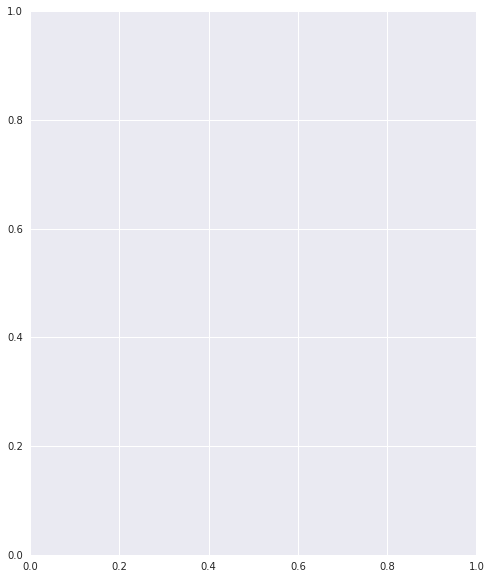

In [9]:

plt.hist([final_array[:300].flatten(), normalized_original_data[-300:].flatten(), normalized_original_data[:300].flatten() ], color=['g', 'r', 'b'], bins=100, range=[-5,5], linewidth=2 ,histtype='step', label=["generated_300", "real_300", "real_another_300"], density=True)
plt.yscale("log")
plt.legend(loc='best')
# plt.savefig("avgpooling_pdf_plot.png", dpi=200)

In [1]:
channel_idx = 4
plt.hist([final_array[:300,:,:,channel_idx].flatten(), normalized_original_data[-300:, channel_idx, :,:].flatten(), normalized_original_data[:300,channel_idx,:,:].flatten() ], color=['g', 'r', 'b'], bins=100, range=[-5,5], linewidth=2 ,histtype='step', label=["generated_300", "real_300", "real_another_300"], density=True)
plt.yscale("log")
plt.legend(loc='best')
# plt.savefig("avgpooling_pdf_plot.png", dpi=200)

NameError: name 'plt' is not defined

In [18]:
%time
# Plotting l2 over images to measure mode collapse

from sklearn.metrics.pairwise import euclidean_distances

def calculateDistance(i1, i2):
    return np.mean((i1-i2)**2)


# np.random.shuffle(generated_image_path)
# np.random.shuffle(real_image_path)


generated_image = final_array[:300]


l2_generated = []
for i, img in tqdm(enumerate(generated_image)):
    foo = [calculateDistance(img,j) for j in generated_image[i+1:]]
    l2_generated.append(foo)
    
fake_distances = [j for i in l2_generated for j in i]



real_image = normalized_original_data[:300]
l2_real = []
for i, img in tqdm(enumerate(real_image)):
    foo = [calculateDistance(img,j) for j in real_image[i+1:]]
    l2_real.append(foo)
    
real_distances = [j for i in l2_real for j in i]

0it [00:00, ?it/s]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10 µs


300it [01:17,  3.87it/s]
300it [01:20,  3.74it/s]


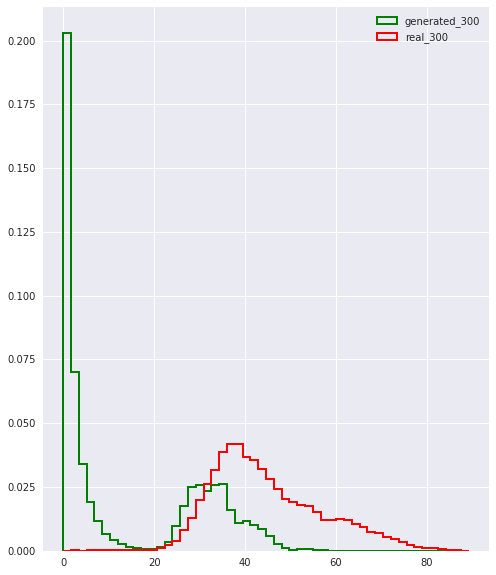

In [19]:


plt.hist([real_distances,  fake_distances ], color=['r',  'g'], bins='fd', linewidth=2 ,histtype='step', label=["real_300",  "generated_300"], density=True)
# plt.yscale("log")
# plt.gca().invert_yaxis()
plt.legend(loc='best')
# plt.savefig("l2_distance_plots_to_quantify_mode_collapse.png", dpi=200)

In [3]:


climate_counter = 246718

climate_npy_files = "/global/cscratch1/sd/rgupta2/backup/climate_stylegan/stored_outputs/wo_norm_512_logan/result/single_generator_results/generator_{}_images_50_file_*.npy".format(climate_counter)
generated_files = sorted(glob(climate_npy_files))[:]

print("Number of files : {}".format(len(generated_files)))

generated_image_list = []
for file in generated_files:
    my_dict_back = np.load(file, allow_pickle=True)	
    generated_images = my_dict_back.item()["generated_images"]
#     print(generated_images.shape)
    generated_image_list.append(np.squeeze(generated_images))
    
generated_images_new = np.concatenate(generated_image_list, axis=0)



Number of files : 12


In [3]:
generated_images_new.shape

(600, 512, 512)

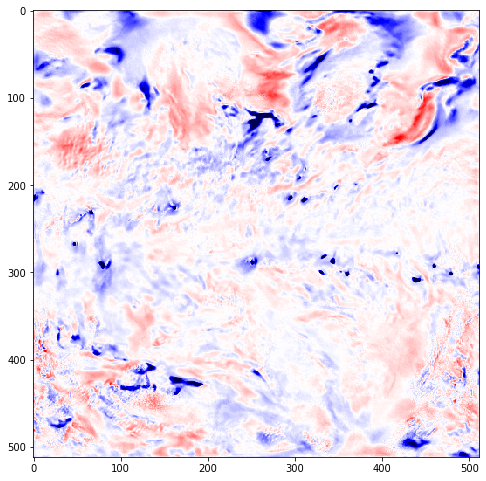

In [4]:
# mpl.rc('image', cmap='seismic')
plt.imshow(generated_images_new[0], cmap='seismic', vmin= -1.4, vmax=1.4);


# cdict = {
#   'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
#   'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
#   'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
# }

# cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

# x = np.arange(0, 10, .1)
# y = np.arange(0, 10, .1)
# X, Y = np.meshgrid(x,y)

# data = 2*( np.sin(X) + np.sin(3*Y) )

# def do_plot(n, f, title):
#     #plt.clf()
#     plt.subplot(1, 3, n)
#     plt.pcolor(X, Y, f(data), cmap=cm, vmin=-4, vmax=4)



In [5]:
# plot original images 

original_wo_norm_data = np.load("/global/cscratch1/sd/rgupta2/backup/climate_stylegan/dataset/climate_data_original/1996.npy")

In [7]:
print(original_wo_norm_data.shape)

(2920, 1, 512, 512)


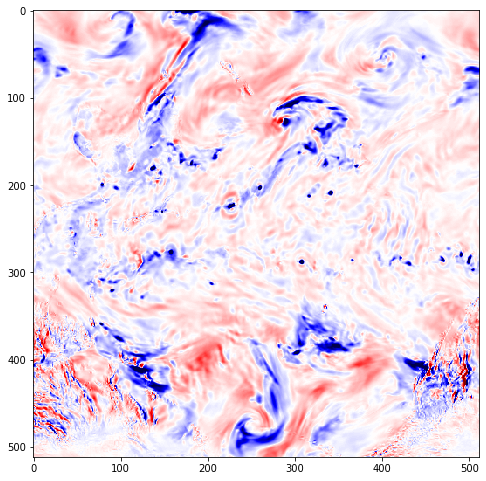

In [8]:

plt.imshow(original_wo_norm_data[3,0], cmap='seismic', vmin= -1.4, vmax=1.4);


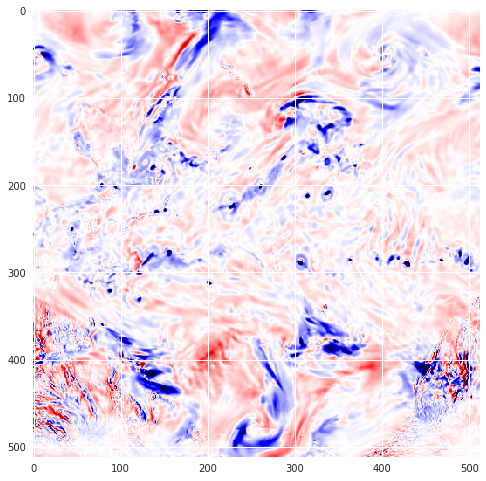

In [29]:
plt.imshow(original_wo_norm_data[4,0], cmap='seismic', vmin= -1.4, vmax=1.4);

In [9]:
# calculating generated_l2_image_plots 
%time
# Plotting l2 over images to measure mode collapse

from sklearn.metrics.pairwise import euclidean_distances

def calculateDistance(i1, i2):
    return np.mean((i1-i2)**2)


np.random.shuffle(generated_images_new)
np.random.shuffle(original_wo_norm_data)


generated_image = generated_images_new[:500]


l2_generated = []
for i, img in tqdm(enumerate(generated_image)):
    foo = [calculateDistance(img,j) for j in generated_image[i+1:]]
    l2_generated.append(foo)
    
fake_distances = [j for i in l2_generated for j in i]



real_image = original_wo_norm_data[:500]
l2_real = []
for i, img in tqdm(enumerate(real_image)):
    foo = [calculateDistance(img,j) for j in real_image[i+1:]]
    l2_real.append(foo)
    
real_distances = [j for i in l2_real for j in i]

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 5.25 µs


500it [00:35, 14.20it/s]
500it [00:35, 14.28it/s]


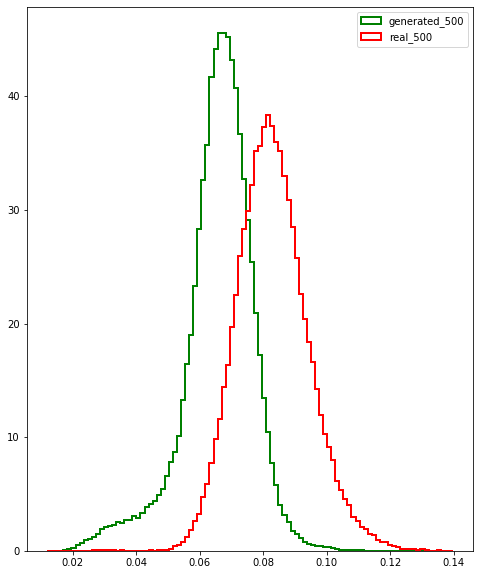

In [10]:
plt.hist([real_distances,  fake_distances ], color=['r',  'g'], bins=100, linewidth=2 ,histtype='step', label=["real_500",  "generated_500"], density=True)
# plt.yscale("log")
# plt.gca().invert_yaxis()
plt.legend(loc='best')
plt.savefig("l2_distance_plots_with_logan_500_images_at_resolution_512_one_unnormalized_channel.png", dpi=200)

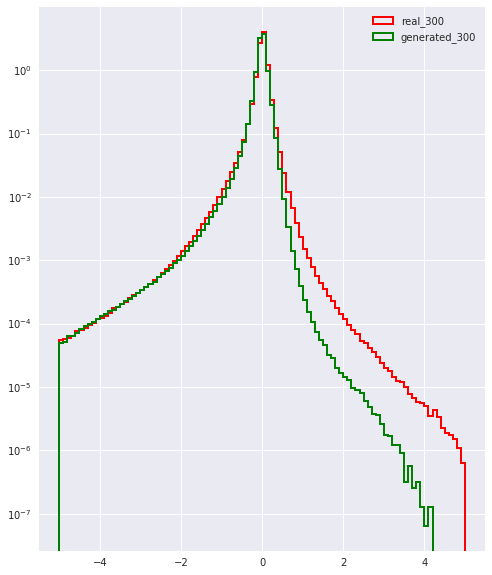

In [35]:
plt.hist([generated_images_new[-600:].flatten(), original_wo_norm_data[-600:].flatten() ], color=['g', 'r'], bins=100, range=[-5,5], linewidth=2 ,histtype='step', label=["generated_300", "real_300"], density=True)
plt.yscale("log")
plt.legend(loc='best')

In [12]:


climate_counter = 246718

climate_npy_files = "/global/cscratch1/sd/rgupta2/backup/climate_stylegan/stored_outputs/wo_norm_512_logan/result/single_generator_results/generator_{}_images_50_file_*.npy".format(climate_counter)
generated_files = sorted(glob(climate_npy_files))[:]

print("Number of files : {}".format(len(generated_files)))

generated_image_list = []
for file in generated_files:
    my_dict_back = np.load(file, allow_pickle=True)	
    generated_images = my_dict_back.item()["generated_images"]
#     print(generated_images.shape)
    generated_image_list.append(np.squeeze(generated_images))
    
generated_images_new = np.concatenate(generated_image_list, axis=0)


# print("total_number_of_files: {} and shape of each file {}".format(len(list_of_generated_images) ,  list_of_generated_images[0].shape))
    
    
save_path = "/global/cscratch1/sd/rgupta2/backup/StyleGAN/Mustafa_files/"

if not os.path.exists(save_path):
    os.makedirs(save_path)


    
# final_array = np.concatenate(list_of_generated_images, axis=0 )
np.save(save_path + "climategan_generator_{}_res_512_images_{}_logan_one_channel_wo_norm.npy".format(climate_counter, len(generated_image_list)*50 ), generated_images_new)

Number of files : 12


In [5]:
# original_seven_channel_normalized_data = "/project/projectdirs/dasrepo/mustafa/data/climate/sims/normalized/"
normalized_original_data = np.load ( "/project/projectdirs/dasrepo/mustafa/data/climate/sims/normalized/normalized_seven_channels_1998.npy")
print(normalized_original_data.shape)
np.random.shuffle(normalized_original_data)


# generated_images_npy
# 159490 the most recent generator counter
climate_counter = 234218
generated_files = "/global/cscratch1/sd/rgupta2/backup/climate_stylegan/stored_outputs/logan_seven_channel_norm/result/single_generator_results/generator_{}_images_50_file_*.npy".format(climate_counter)
# generated_files = sorted(glob(climate_npy_files))[:9]

print("Number of files : {}".format(len(generated_files)))

generated_image_list = []
for file in generated_files:
    my_dict_back = np.load(file, allow_pickle=True)	
    generated_images = my_dict_back.item()["generated_images"]
#     print(generated_images.shape)
    generated_image_list.append(np.squeeze(generated_images))
    
generated_images_new = np.concatenate(generated_image_list, axis=0)


print(generated_image_list[0].shape)
print(generated_images_new.shape)



(2920, 7, 512, 512)
Number of files : 162


IsADirectoryError: [Errno 21] Is a directory: '/'

In [68]:
# Metrics for seven channel logan normalized







normalized_original_data = np.load ( "/project/projectdirs/dasrepo/mustafa/data/climate/sims/normalized/normalized_seven_channels_1998.npy")
print(normalized_original_data.shape)
np.random.shuffle(normalized_original_data)


# generated_images_npy
# 159490 the most recent generator counter
climate_counter = 266718

load_path = "/global/cscratch1/sd/rgupta2/backup/climate_stylegan/test_samples/"

generated_data = np.load (load_path+ "logan_seven_channel_norm_climate_images_at_generator_{}_512.npy".format(climate_counter))
print(generated_data.shape)
np.random.shuffle(generated_data)
print(generated_data.shape)









(2920, 7, 512, 512)
(850, 512, 512, 7)
(850, 512, 512, 7)


In [38]:
tmp_data = normalized_original_data[3,-3]
print(tmp_data.shape)
print(tmp_data[0, :100])



(512, 512)
[6.9425907 6.7202616 6.516955  6.2837396 6.0559916 5.850993  5.691561
 5.555858  5.428604  5.329761  5.292201  5.2097373 5.2125807 5.1495404
 5.170825  5.186826  5.171027  5.2276278 5.2336698 5.203356  5.1837683
 5.271399  5.306264  5.3568788 5.4228134 5.510313  5.5263186 5.3989553
 5.203121  5.1060524 5.1943097 5.386286  5.535398  5.59403   5.616801
 5.6302543 5.62579   5.5770783 5.532463  5.5668626 5.6065555 5.7551856
 6.0204606 6.4592    6.7956376 7.1547656 7.4890614 7.723973  7.811375
 7.7347007 7.651429  7.635578  7.9035273 8.373149  8.775997  9.221184
 9.514526  9.23267   8.827881  8.092298  7.706694  7.4047127 6.9783263
 6.423899  5.8795896 5.433566  5.0645494 4.77142   4.6521273 4.744652
 4.930495  5.1132927 5.397612  5.8894053 6.390346  6.5239835 6.180243
 5.618766  5.171645  4.905697  4.6828437 4.4406104 4.2267475 4.0659466
 3.9325707 3.8507893 3.9004714 4.060896  4.168848  4.1600738 4.215015
 4.477601  4.75591   4.712324  4.230525  3.6525729 3.4125614 3.4859989
 3

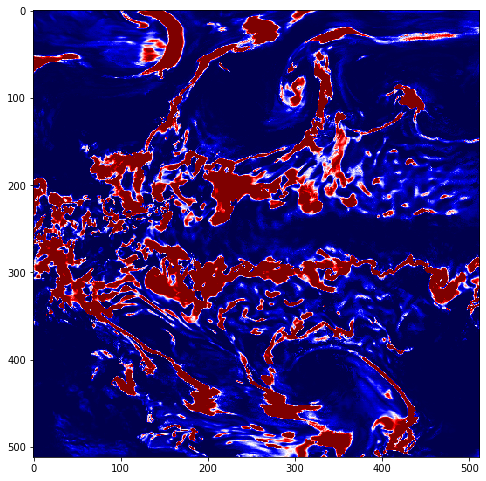

In [33]:

plt.imshow(normalized_original_data[3,0], cmap='seismic', vmin=1e-8, vmax=1e-4);


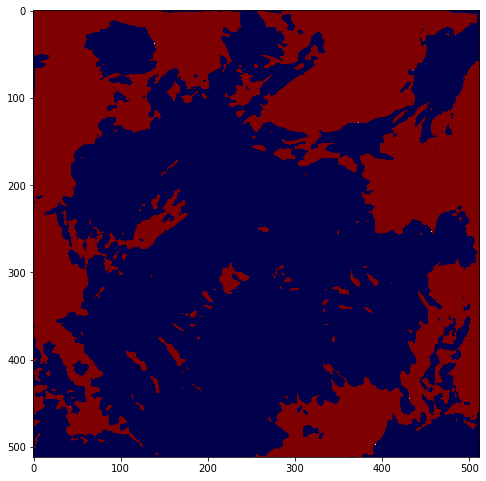

In [34]:
plt.imshow(generated_data[3, :, : ,0], cmap='seismic', vmin=1e-8, vmax=1e-4);

In [ ]:
plt.imshow(generated_data[3,0], cmap='seismic', vmin= -1.4, vmax=1.4);

500it [05:25,  1.54it/s]
500it [05:21,  1.56it/s]


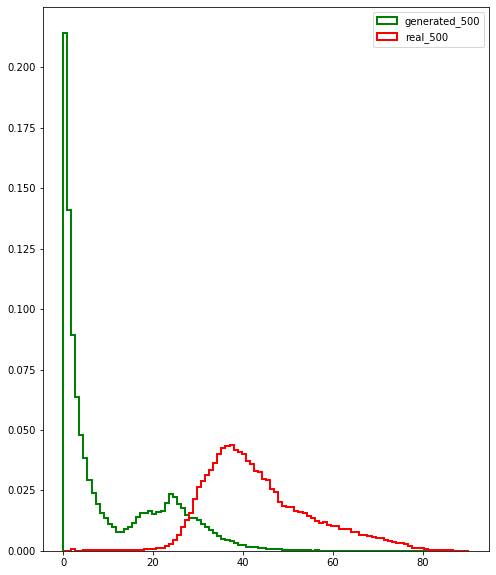

100it [00:11,  8.44it/s]
100it [00:03, 30.30it/s]


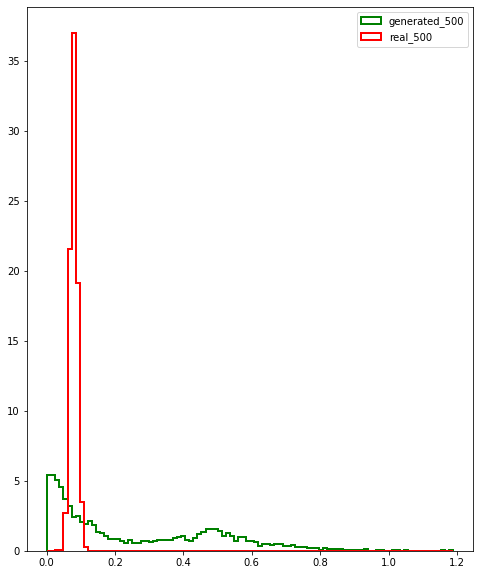

100it [00:11,  8.50it/s]
100it [00:02, 39.92it/s]
100it [00:10,  9.82it/s]
100it [00:02, 41.44it/s]
100it [00:10,  9.64it/s]
100it [00:02, 41.31it/s]
100it [00:10,  9.20it/s]
100it [00:02, 40.78it/s]
100it [00:10,  9.28it/s]
100it [00:02, 34.98it/s]
100it [00:11,  8.57it/s]
100it [00:02, 40.56it/s]
100it [00:10,  9.50it/s]
100it [00:02, 39.55it/s]


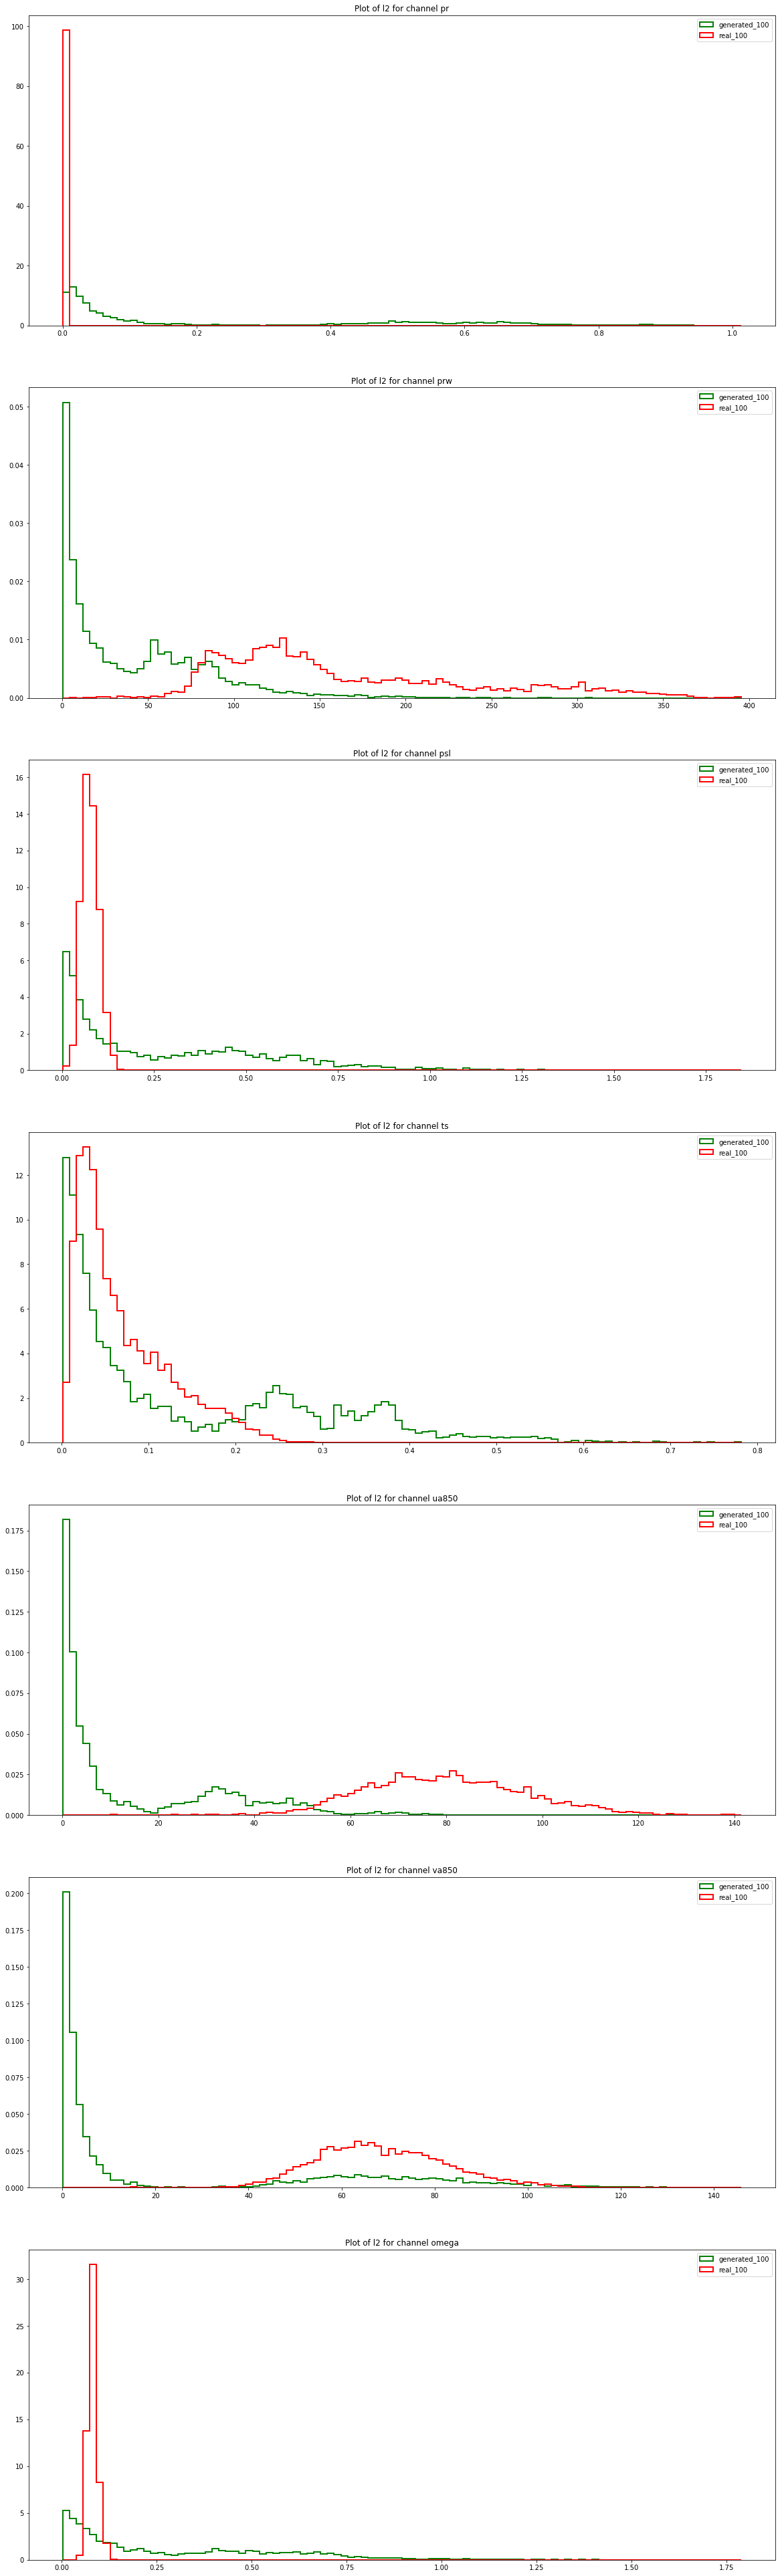

In [70]:


channels = 7
number_l2 = 100

fig, axs = plt.subplots(nrows=channels, figsize=(20, channels*10))
# for i, y_ax in enumerate(ys):
#     pd.Series(y_ax, index=x_ax).plot(kind='bar', ax=axs[i])



channel_names = ["pr", "prw", "psl", "ts", "ua850", "va850", "omega"]
    
for chan in range(channels):
    generated_image = generated_data[:number_l2, :, :, chan]
    real_image = normalized_original_data[:number_l2, chan,]
    l2_generated = []
    for i, img in tqdm(enumerate(generated_image)):
        foo = [calculateDistance(img,j) for j in generated_image[i+1:]]
        l2_generated.append(foo)

    fake_distances = [j for i in l2_generated for j in i]



    l2_real = []
    for i, img in tqdm(enumerate(real_image)):
        foo = [calculateDistance(img,j) for j in real_image[i+1:]]
        l2_real.append(foo)
    real_distances = [j for i in l2_real for j in i]

    axs[chan].hist([real_distances,  fake_distances ], color=['r',  'g'], bins=100, linewidth=2 ,histtype='step', label=["real_{}".format(number_l2),  "generated_{}".format(number_l2)], density=True)
    axs[chan].set_title('Plot of l2 for channel {}'.format(channel_names[chan]))
    # plt.yscale("log")
    # plt.gca().invert_yaxis()
    axs[chan].legend(loc='best')
    
plt.savefig("./seven_channel_normalized_logan_l2_plots_266718.png")

In [ ]:
#  only omega single channel wo_norm





################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
# Single channel wo norm
# 
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################






In [71]:


climate_counter = 246718

load_path = "/global/cscratch1/sd/rgupta2/backup/climate_stylegan/test_samples/"

omega_generated_data = np.load (load_path + "logan_climate_images_at_generator_{}_wo_norm_512.npy".format(climate_counter))
np.random.shuffle(omega_generated_data)
print(omega_generated_data.shape)









unnormalized_omega_data = np.load ( "/project/projectdirs/dasrepo/mustafa/data/climate/sims/unnormalized/seven_channels_1998.npy")
np.random.shuffle(unnormalized_omega_data)
print(unnormalized_omega_data.shape)

(600, 512, 512, 1)
(2920, 7, 512, 512)


100it [00:02, 41.60it/s]
100it [00:02, 40.29it/s]


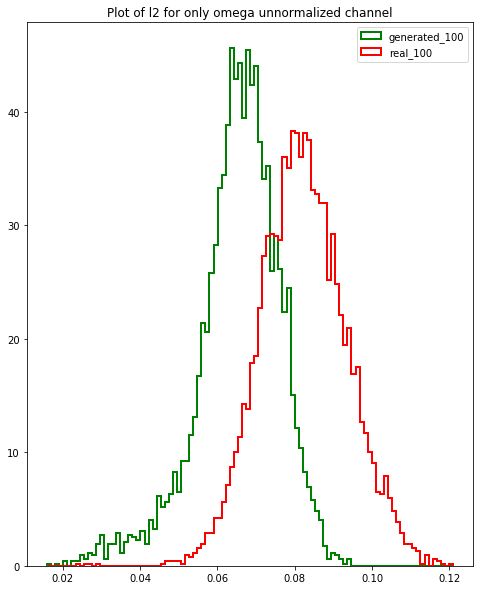

In [72]:




number_l2 = 100

# fig, axs = plt.subplots( figsize=(10, 5))
# for i, y_ax in enumerate(ys):
#     pd.Series(y_ax, index=x_ax).plot(kind='bar', ax=axs[i])

    





generated_image = omega_generated_data[:number_l2, :, :, 0]
real_image = unnormalized_omega_data[:number_l2,-1,:,:]














l2_generated = []
for i, img in tqdm(enumerate(generated_image)):
    foo = [calculateDistance(img,j) for j in generated_image[i+1:]]
    l2_generated.append(foo)

fake_distances = [j for i in l2_generated for j in i]



l2_real = []
for i, img in tqdm(enumerate(real_image)):
    foo = [calculateDistance(img,j) for j in real_image[i+1:]]
    l2_real.append(foo)
real_distances = [j for i in l2_real for j in i]

plt.hist([real_distances,  fake_distances ], color=['r',  'g'], bins=100, linewidth=2 ,histtype='step', label=["real_{}".format(number_l2),  "generated_{}".format(number_l2)], density=True)
plt.title('Plot of l2 for only omega unnormalized channel')
# plt.yscale("log")
# plt.gca().invert_yaxis()
plt.legend(loc='best')
plt.savefig("l2_image_plot_omega_only_unnormalized.png")

In [3]:





normalized_original_data = np.load ( "/project/projectdirs/dasrepo/mustafa/data/climate/sims/normalized/normalized_seven_channels_1998.npy")

normalized_original_data = normalized_original_data[:, -3:]

print(normalized_original_data.shape)
np.random.shuffle(normalized_original_data)


# generated_images_npy
# 159490 the most recent generator counter
climate_counter = 267968
load_path = "/global/cscratch1/sd/rgupta2/backup/climate_stylegan/test_samples/"
generated_three_channel_data = np.load (load_path+ "logan_three_channel_norm_climate_images_at_generator_{}_512.npy".format(climate_counter))
np.random.shuffle(generated_three_channel_data)
print(generated_three_channel_data.shape)





# save_path = "/global/cscratch1/sd/rgupta2/backup/climate_stylegan/test_samples/"
# np.save(save_path + "logan_three_channel_norm_climate_images_at_generator_{}_512.npy".format(counter), final_array)

(2920, 3, 512, 512)
(1000, 512, 512, 3)


100it [00:04, 23.28it/s]
100it [00:02, 41.79it/s]
100it [00:04, 23.99it/s]
100it [00:02, 41.23it/s]
100it [00:04, 23.14it/s]
100it [00:02, 44.07it/s]


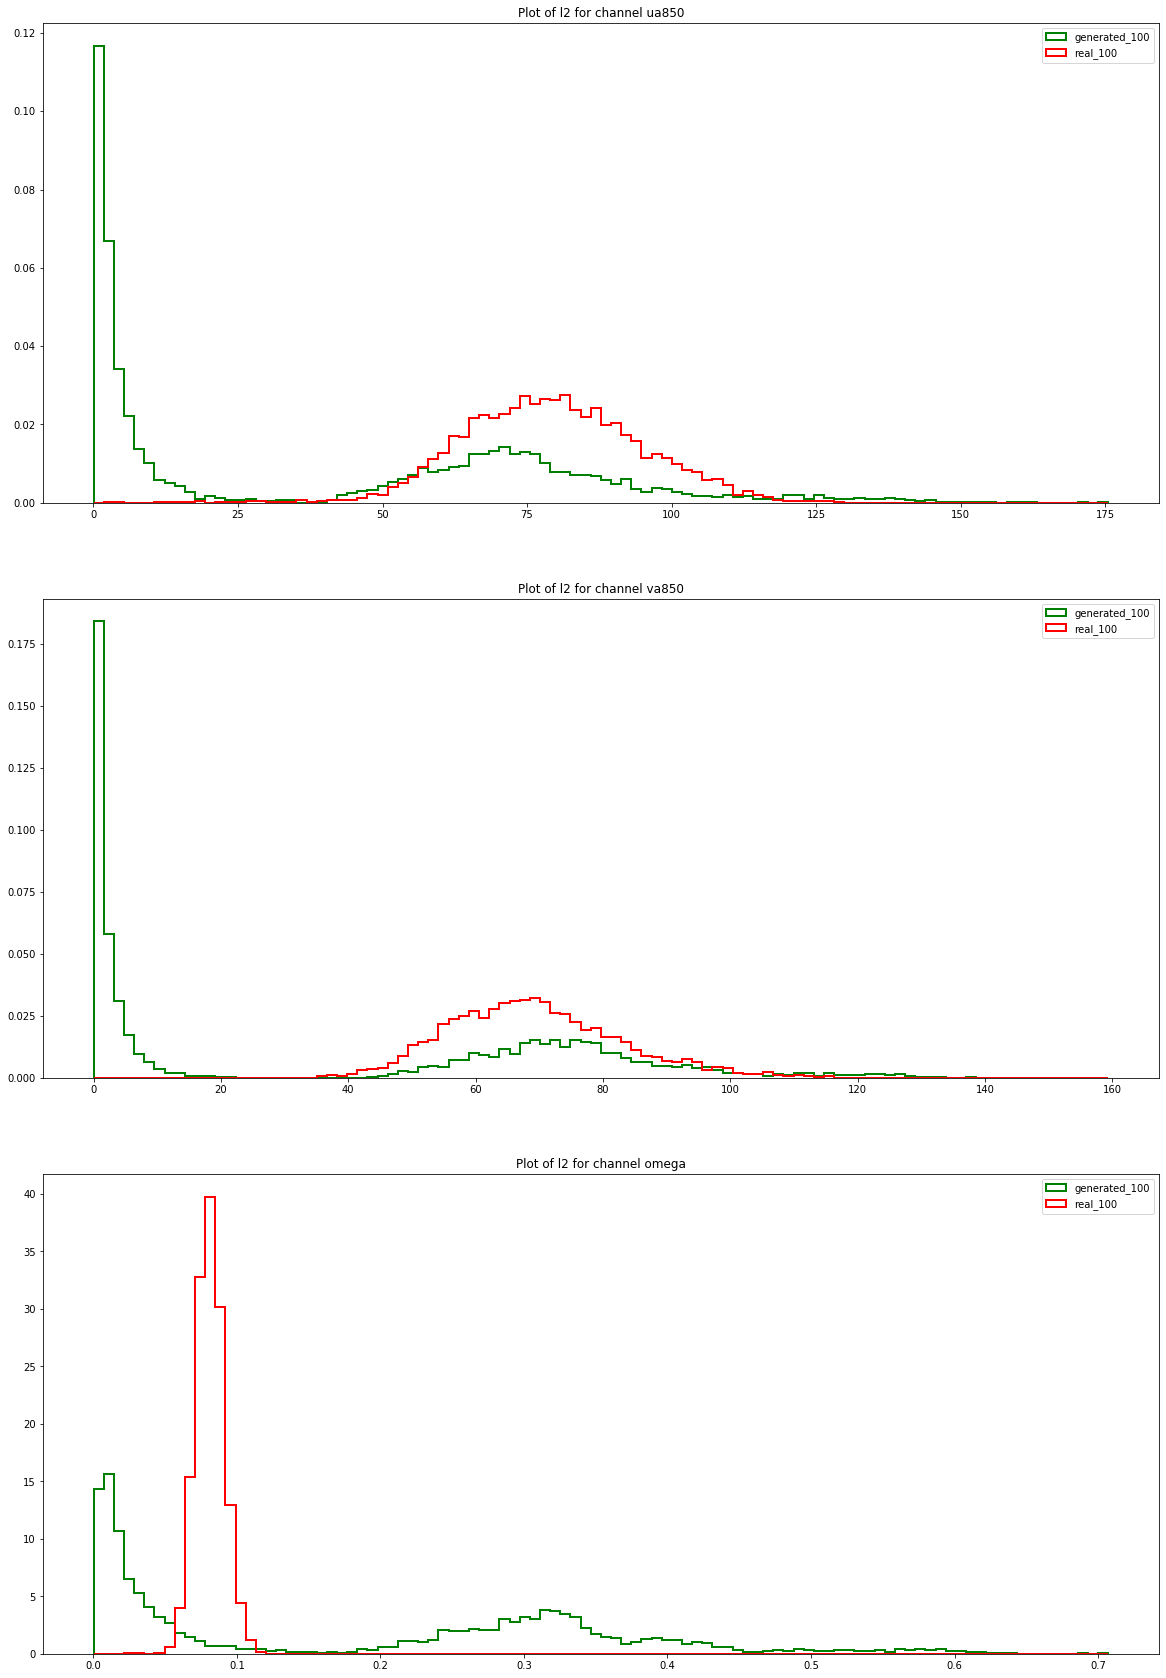

In [7]:




channels = 3
number_l2 = 100

fig, axs = plt.subplots(nrows=channels, figsize=(20, channels*10))
# for i, y_ax in enumerate(ys):
#     pd.Series(y_ax, index=x_ax).plot(kind='bar', ax=axs[i])

def calculateDistance(i1, i2):
    return np.mean((i1-i2)**2)

channel_names = ["ua850", "va850", "omega"]
    
for chan in range(channels):
    generated_image = generated_three_channel_data[:number_l2, :, :, chan]
    real_image = normalized_original_data[:number_l2, chan,]
    l2_generated = []
    for i, img in tqdm(enumerate(generated_image)):
        foo = [calculateDistance(img,j) for j in generated_image[i+1:]]
        l2_generated.append(foo)

    fake_distances = [j for i in l2_generated for j in i]



    l2_real = []
    for i, img in tqdm(enumerate(real_image)):
        foo = [calculateDistance(img,j) for j in real_image[i+1:]]
        l2_real.append(foo)
    real_distances = [j for i in l2_real for j in i]

    axs[chan].hist([real_distances,  fake_distances ], color=['r',  'g'], bins=100, linewidth=2 ,histtype='step', label=["real_{}".format(number_l2),  "generated_{}".format(number_l2)], density=True)
    axs[chan].set_title('Plot of l2 for channel {}'.format(channel_names[chan]))
    # plt.yscale("log")
    # plt.gca().invert_yaxis()
    axs[chan].legend(loc='best')
    
plt.savefig("./three_channel_normalized_logan_l2_plots_267968.png")

In [3]:
counter = 104218

load_path = "/global/cscratch1/sd/rgupta2/backup/climate_stylegan/test_samples/"    
generated_image = np.load(load_path + "128_dimensional_logan_one_channel_norm_climate_images_at_generator_{}_512.npy".format(counter))

In [ ]:




# channels = 3
# number_l2 = 100

fig, axs = plt.subplots(nrows=channels, figsize=(20, channels*10))
# for i, y_ax in enumerate(ys):
#     pd.Series(y_ax, index=x_ax).plot(kind='bar', ax=axs[i])

def calculateDistance(i1, i2):
    return np.mean((i1-i2)**2)

# channel_names = ["ua850", "va850", "omega"]
channels =1
for chan in range(channels):
    
#     generated_image =  generated_three_channel_data[:number_l2, :, :, chan]
#     real_image = normalized_original_data[:number_l2, chan,]
    l2_generated = []
    for i, img in tqdm(enumerate(generated_image[:100])):
        foo = [calculateDistance(img,j) for j in generated_image[i+1:]]
        l2_generated.append(foo)

    fake_distances = [j for i in l2_generated for j in i]



#     l2_real = []
#     for i, img in tqdm(enumerate(real_image)):
#         foo = [calculateDistance(img,j) for j in real_image[i+1:]]
#         l2_real.append(foo)
#     real_distances = [j for i in l2_real for j in i]

    axs[chan].hist([  fake_distances ], color=[ 'g'], bins=100, linewidth=2 ,histtype='step', label=[ "generated_{}".format(number_l2)], density=True)
    axs[chan].set_title('Plot of l2 for channel {}'.format(channel_names[chan]))
    # plt.yscale("log")
    # plt.gca().invert_yaxis()
    axs[chan].legend(loc='best')
    
plt.savefig("./three_channel_normalized_logan_l2_plots_267968.png")